In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Data preparation

In [2]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

--2025-10-29 16:40:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ... 
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.08s   

2025-10-29 16:40:29 (9.89 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [5]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [6]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [7]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [8]:
df = df.fillna(0)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df), len(df_full_train),len(df_train), len(df_val), len(df_test)

(9704, 7763, 5822, 1941, 1941)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

In [17]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

## Question 1

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [19]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [20]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [25]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [30]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Question 2

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [34]:
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [35]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [36]:
X_val = dv.transform(val_dicts)

In [40]:
y_pred = rf.predict(X_val)
y_pred

array([18.62889858, 15.29598647, 18.22879442, ..., 14.80283652,
       13.49358341, 15.99288211])

In [42]:
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(3.5910988906520895)

## Question 3

In [51]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse=np.sqrt(mean_squared_error(y_test, y_pred))

    scores.append((n, rmse))

In [52]:
df_scores = pd.DataFrame(scores, columns=('n_estimators','rmse'))

In [53]:
df_scores

,n_estimators,rmse
0,10,3.591099
1,20,3.591085
2,30,3.592202
3,40,3.591646
4,50,3.591331
5,60,3.590818
6,70,3.590880
7,80,3.590769
8,90,3.590229
9,100,3.590499


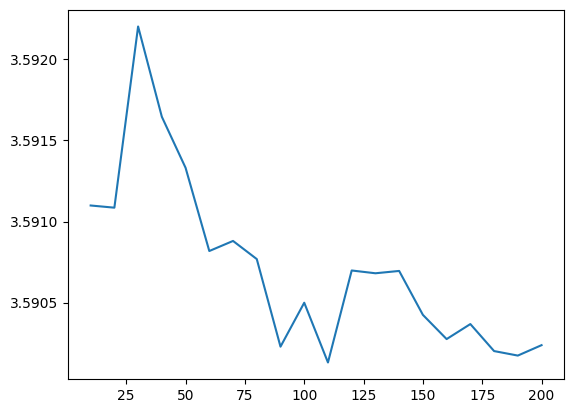

In [54]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4 

In [79]:
scores = []
max_depth = [10, 15, 20, 25]
for d in max_depth:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth = d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse=np.sqrt(mean_squared_error(y_test, y_pred))

        scores.append((n, d, rmse))

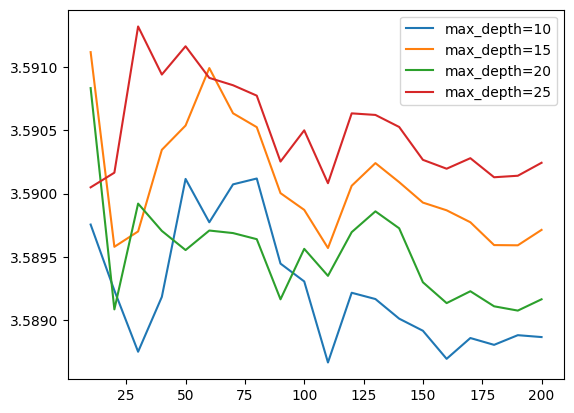

In [80]:
df_scores = pd.DataFrame(scores, columns=('n_estimators','max_depth','rmse'))


for depth in df_scores.max_depth.unique():
    subset = df_scores[df_scores.max_depth ==depth]
    
    plt.plot(subset.n_estimators, subset.rmse, label = f"max_depth={depth}")


plt.legend()
plt.show()

## Question 5

In [82]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))

In [86]:
feature_names = dv.get_feature_names_out()  # feature names
feature_importances = pd.Series(rf.feature_importances_, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

vehicle_weight                  0.959162
horsepower                      0.016040
acceleration                    0.011471
engine_displacement             0.003269
model_year                      0.003182
num_cylinders                   0.002359
num_doors                       0.001591
origin=USA                      0.000555
origin=Europe                   0.000520
origin=Asia                     0.000476
drivetrain=All-wheel drive      0.000382
fuel_type=Diesel                0.000344
fuel_type=Gasoline              0.000337
drivetrain=Front-wheel drive    0.000312
dtype: float64


## Question 6

In [88]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00


In [89]:
import xgboost as xgb

In [90]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names=features)

In [91]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [92]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [95]:
y_pred = model.predict(dval)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(3.5973930278365014)

In [96]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(3.597789950389413)